In [7]:
from keras.datasets import mnist
import numpy as np
from matplotlib import pyplot as plt
#import dionysus as d
from sklearn.model_selection import train_test_split
import math
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import LinearSVC, SVC, NuSVC
#from libsvm.svmutil import *
from sklearn.preprocessing import scale
import sys
import pandas as pd
#from persim import PersImage

#sys.path.append('../persistence_methods')
#import ATS
#from persistence_methods_numba import reshape_persistence_diagrams
#from persistence_methods import kernel_features
#from persistence_methods import tent_features
#from persistence_methods import carlsson_coordinates
#from persistence_methods import adaptive_features
#from persistence_methods import landscape_features
#from persistence_methods import persistence_image_features
#from persistence_methods import fast_kernel_features
#from persistence_methods_numba import numba_kernel_features_train
#from persistence_methods_numba import numba_kernel_features_test

In [8]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()

In [9]:
def directional_transform(img):
    z = np.array([0,1])
    z = z.reshape([1,2])
    left_to_right = np.zeros((28,28))
    for i in range(0,28):
        for j in range(0,28):
            if img[i,j] != 0:
                left_to_right[i,j] = np.inner([i,j],z)
            else:
                left_to_right[i,j] = 0

    z = np.array([0,-1])
    z = z.reshape([1,2])
    right_to_left = np.zeros((28,28))
    for i in range(0,28):
        for j in range(0,28):
            if img[i,j] != 0:
                right_to_left[i,j] = abs(28 + np.inner([i,j],z))
            else:
                right_to_left[i,j] = 0

    z = np.array([1,0])
    z = z.reshape([1,2])
    bottom_to_top = np.zeros((28,28))
    for i in range(0,28):
        for j in range(0,28):
            if img[i,j] != 0:
                bottom_to_top[i,j] = np.inner([i,j],z)
            else:
                bottom_to_top[i,j] = 0

    z = np.array([-1,0])
    z = z.reshape([1,2])
    top_to_bottom = np.zeros((28,28))
    for i in range(0,28):
        for j in range(0,28):
            if img[i,j] != 0:
                top_to_bottom[i,j] = abs(28 + np.inner([i,j],z))
            else:
                top_to_bottom[i,j] = 0
    imgs = [left_to_right, right_to_left, bottom_to_top, top_to_bottom]
    return imgs

label:  8


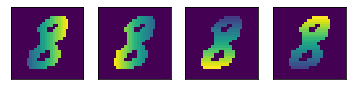

In [13]:
n=110
label = test_y[n]
print("label: ", label)
imgs = directional_transform(test_X[n])
f, axarr = plt.subplots(1,4)
ltr = axarr[0].imshow(imgs[0])
ltr.axes.get_xaxis().set_visible(False)
ltr.axes.get_yaxis().set_visible(False)
rtl = axarr[1].imshow(imgs[1])
rtl.axes.get_xaxis().set_visible(False)
rtl.axes.get_yaxis().set_visible(False)
ttb = axarr[2].imshow(imgs[2])
ttb.axes.get_xaxis().set_visible(False)
ttb.axes.get_yaxis().set_visible(False)
btt = axarr[3].imshow(imgs[3])
btt.axes.get_xaxis().set_visible(False)
btt.axes.get_yaxis().set_visible(False)
plt.savefig('mnist_eight_sweeps.png')


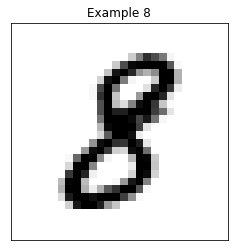

In [5]:
fig = plt.imshow(test_X[n],cmap='gray_r')
plt.title('Example 8')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.savefig('mnist_eight.png')

label:  3


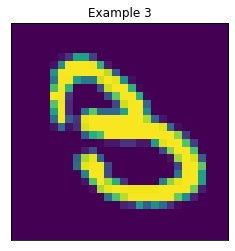

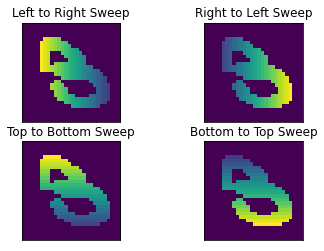

In [6]:
n=18
label = test_y[n]
print("label: ", label)
imgs = directional_transform(test_X[n])
fig = plt.imshow(test_X[n])
plt.title('Example 3')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.savefig('mnist_zero.png')
f, axarr = plt.subplots(2,2)
ltr = axarr[0,1].imshow(imgs[0])
ltr.axes.get_xaxis().set_visible(False)
ltr.axes.get_yaxis().set_visible(False)
axarr[0, 0].set_title("Left to Right Sweep")
rtl = axarr[0,0].imshow(imgs[1])
rtl.axes.get_xaxis().set_visible(False)
rtl.axes.get_yaxis().set_visible(False)
axarr[0, 1].set_title("Right to Left Sweep")
ttb = axarr[1,1].imshow(imgs[2])
ttb.axes.get_xaxis().set_visible(False)
ttb.axes.get_yaxis().set_visible(False)
axarr[1, 0].set_title("Top to Bottom Sweep")
btt = axarr[1,0].imshow(imgs[3])
btt.axes.get_xaxis().set_visible(False)
btt.axes.get_yaxis().set_visible(False)
axarr[1, 1].set_title("Bottom to Top Sweep")
plt.savefig('mnist_eight_sweeps.png')



In [7]:
def compute_persistence(directional_transform):
    f_lower_star = d.fill_freudenthal(directional_transform, reverse = True)
    p = d.homology_persistence(f_lower_star)
    dgms_lower = d.init_diagrams(p, f_lower_star)
    return dgms_lower

In [8]:
def append_dim_list(dgms, dim_list):
    jth_pt = []
    for k in range(0, len(dgms)):
        if dgms[k].death - dgms[k].birth >=0:
            birth = dgms[k].birth
            death = dgms[k].death
        else:
            birth = dgms[k].death
            death = dgms[k].birth
        if math.isinf(death):
            b = 50
        else:
            b = death
        t = [birth, b]
        jth_pt.append(t)
    dim_list.append(np.array(jth_pt))

In [9]:
tuning = np.arange(0,10000)
unused_index, tuning_index = train_test_split(tuning, test_size = .1, random_state=1)
n = tuning_index.shape[0]
obs = np.arange(0,n)
zero_dim_0 = []
zero_dim_1 = []
zero_dim_2 = []
zero_dim_3 = []
one_dim_0 = []
one_dim_1 = []
one_dim_2 = []
one_dim_3 = []
for i in tuning_index:
    img = test_X[i]
    imgs = directional_transform(img)
    for j in range(0,4):
        print(type(imgs[j]))
        dgms_lower= compute_persistence(imgs[j])
        if j == 0:
            append_dim_list(dgms_lower[0], zero_dim_0)
            append_dim_list(dgms_lower[1], one_dim_0)
        if j == 1:
            append_dim_list(dgms_lower[0], zero_dim_1)
            append_dim_list(dgms_lower[1], one_dim_1)
        if j == 2:
            append_dim_list(dgms_lower[0], zero_dim_2)
            append_dim_list(dgms_lower[1], one_dim_2)
        if j == 3:
            append_dim_list(dgms_lower[0], zero_dim_3)
            append_dim_list(dgms_lower[1], one_dim_3)    

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.nd

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.nd

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.nd

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.nd

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.nd

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.nd

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.nd

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.nd

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.nd

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.nd

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.nd

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [10]:
train_index, test_index, original_index_train, original_index_test, y_train, y_test = train_test_split(obs, tuning_index, test_y[tuning_index], test_size = .2, random_state=1, stratify = train_y[tuning_index])

In [11]:
zero_dim_ltr_train = np.array(zero_dim_0)[train_index]
zero_dim_rtl_train = np.array(zero_dim_1)[train_index]
zero_dim_ttb_train = np.array(zero_dim_2)[train_index]
zero_dim_btt_train = np.array(zero_dim_3)[train_index]

zero_dim_ltr_test = np.array(zero_dim_0)[test_index]
zero_dim_rtl_test = np.array(zero_dim_1)[test_index]
zero_dim_ttb_test = np.array(zero_dim_2)[test_index]
zero_dim_btt_test = np.array(zero_dim_3)[test_index]


one_dim_ltr_train = np.array(one_dim_0)[train_index]
one_dim_rtl_train = np.array(one_dim_1)[train_index]
one_dim_ttb_train = np.array(one_dim_2)[train_index]
one_dim_btt_train = np.array(one_dim_3)[train_index]

one_dim_ltr_test = np.array(one_dim_0)[test_index]
one_dim_rtl_test = np.array(one_dim_1)[test_index]
one_dim_ttb_test = np.array(one_dim_2)[test_index]
one_dim_btt_test = np.array(one_dim_3)[test_index]

In [12]:
dgms_lower= compute_persistence(imgs[0])

if (dgms_lower[0][1].death - dgms_lower[0][1].birth)>=0:
    print('Regular')
else:
    print('inverted')

inverted


### 0 Dim Homology

### LTR Carlson Coordinates

In [20]:
X_train_features_0_ltr_cc1, X_train_features_0_ltr_cc2, X_train_features_0_ltr_cc3, X_train_features_0_ltr_cc4, X_test_features_0_ltr_cc1, X_test_features_0_ltr_cc2, X_test_features_0_ltr_cc3, X_test_features_0_ltr_cc4 = carlsson_coordinates(zero_dim_ltr_train, zero_dim_ltr_test)
X_train_features_1_ltr_cc1, X_train_features_1_ltr_cc2, X_train_features_1_ltr_cc3, X_train_features_1_ltr_cc4, X_test_features_1_ltr_cc1, X_test_features_1_ltr_cc2, X_test_features_1_ltr_cc3, X_test_features_1_ltr_cc4 = carlsson_coordinates(one_dim_ltr_train, one_dim_ltr_test)

50.0
Total Time (Carlsson Coordinates):  0.029944181442260742
22.0
Total Time (Carlsson Coordinates):  0.025234222412109375


### RTL Carlson Coordinate

In [21]:
X_train_features_0_rtl_cc1, X_train_features_0_rtl_cc2, X_train_features_0_rtl_cc3, X_train_features_0_rtl_cc4, X_test_features_0_rtl_cc1, X_test_features_0_rtl_cc2, X_test_features_0_rtl_cc3, X_test_features_0_rtl_cc4 = carlsson_coordinates(zero_dim_rtl_train, zero_dim_rtl_test)
X_train_features_1_rtl_cc1, X_train_features_1_rtl_cc2, X_train_features_1_rtl_cc3, X_train_features_1_rtl_cc4, X_test_features_1_rtl_cc1, X_test_features_1_rtl_cc2, X_test_features_1_rtl_cc3, X_test_features_1_rtl_cc4 = carlsson_coordinates(one_dim_rtl_train, one_dim_rtl_test)

50.0
Total Time (Carlsson Coordinates):  0.030398130416870117
19.0
Total Time (Carlsson Coordinates):  0.024638891220092773


### Bottom to Top

In [22]:
X_train_features_0_btt_cc1, X_train_features_0_btt_cc2, X_train_features_0_btt_cc3, X_train_features_0_btt_cc4, X_test_features_0_btt_cc1, X_test_features_0_btt_cc2, X_test_features_0_btt_cc3, X_test_features_0_btt_cc4 = carlsson_coordinates(zero_dim_btt_train, zero_dim_btt_test)
X_train_features_1_btt_cc1, X_train_features_1_btt_cc2, X_train_features_1_btt_cc3, X_train_features_1_btt_cc4, X_test_features_1_btt_cc1, X_test_features_1_btt_cc2, X_test_features_1_btt_cc3, X_test_features_1_btt_cc4 = carlsson_coordinates(one_dim_btt_train, one_dim_btt_test)

50.0
Total Time (Carlsson Coordinates):  0.02856898307800293
21.0
Total Time (Carlsson Coordinates):  0.02515697479248047


### Top to Bottom

In [23]:
X_train_features_0_ttb_cc1, X_train_features_0_ttb_cc2, X_train_features_0_ttb_cc3, X_train_features_0_ttb_cc4, X_test_features_0_ttb_cc1, X_test_features_0_ttb_cc2, X_test_features_0_ttb_cc3, X_test_features_0_ttb_cc4 = carlsson_coordinates(zero_dim_ttb_train, zero_dim_ttb_test)
X_train_features_1_ttb_cc1, X_train_features_1_ttb_cc2, X_train_features_1_ttb_cc3, X_train_features_1_ttb_cc4, X_test_features_1_ttb_cc1, X_test_features_1_ttb_cc2, X_test_features_1_ttb_cc3, X_test_features_1_ttb_cc4 = carlsson_coordinates(one_dim_ttb_train, one_dim_ttb_test)

50.0
Total Time (Carlsson Coordinates):  0.030210018157958984
20.0
Total Time (Carlsson Coordinates):  0.024061203002929688


In [24]:
X_train_features = np.column_stack((scale(X_train_features_0_ltr_cc1), scale(X_train_features_0_ltr_cc2),scale(X_train_features_0_ltr_cc3),scale(X_train_features_0_ltr_cc4),
                                   scale(X_train_features_0_rtl_cc1), scale(X_train_features_0_rtl_cc2),scale(X_train_features_0_rtl_cc3),scale(X_train_features_0_rtl_cc4),
                                   scale(X_train_features_0_ttb_cc1), scale(X_train_features_0_ttb_cc2),scale(X_train_features_0_ttb_cc3),scale(X_train_features_0_ttb_cc4),
                                   scale(X_train_features_0_btt_cc1), scale(X_train_features_0_btt_cc2),scale(X_train_features_0_btt_cc3),scale(X_train_features_0_btt_cc4),
                                   scale(X_train_features_1_ltr_cc1), scale(X_train_features_1_ltr_cc2),scale(X_train_features_1_ltr_cc3),scale(X_train_features_1_ltr_cc4),
                                   scale(X_train_features_1_rtl_cc1), scale(X_train_features_1_rtl_cc2),scale(X_train_features_1_rtl_cc3),scale(X_train_features_1_rtl_cc4),
                                   scale(X_train_features_1_ttb_cc1), scale(X_train_features_1_ttb_cc2),scale(X_train_features_1_ttb_cc3),scale(X_train_features_1_ttb_cc4),
                                   scale(X_train_features_1_btt_cc1), scale(X_train_features_1_btt_cc2),scale(X_train_features_1_btt_cc3),scale(X_train_features_1_btt_cc4)))

X_test_features = np.column_stack((scale(X_test_features_0_ltr_cc1), scale(X_test_features_0_ltr_cc2), scale(X_test_features_0_ltr_cc3), scale(X_test_features_0_ltr_cc4),
                                  scale(X_test_features_0_rtl_cc1), scale(X_test_features_0_rtl_cc2), scale(X_test_features_0_rtl_cc3), scale(X_test_features_0_rtl_cc4),
                                   scale(X_test_features_0_ttb_cc1), scale(X_test_features_0_ttb_cc2), scale(X_test_features_0_ttb_cc3), scale(X_test_features_0_ttb_cc4),
                                  scale(X_test_features_0_btt_cc1), scale(X_test_features_0_btt_cc2), scale(X_test_features_0_btt_cc3), scale(X_test_features_0_btt_cc4),
                                  scale(X_test_features_1_ltr_cc1), scale(X_test_features_1_ltr_cc2), scale(X_test_features_1_ltr_cc3), scale(X_test_features_1_ltr_cc4),
                                  scale(X_test_features_1_rtl_cc1), scale(X_test_features_1_rtl_cc2), scale(X_test_features_1_rtl_cc3), scale(X_test_features_1_rtl_cc4),
                                   scale(X_test_features_1_ttb_cc1), scale(X_test_features_1_ttb_cc2), scale(X_test_features_1_ttb_cc3), scale(X_test_features_1_ttb_cc4),
                                  scale(X_test_features_1_btt_cc1), scale(X_test_features_1_btt_cc2), scale(X_test_features_1_btt_cc3), scale(X_test_features_1_btt_cc4)))

/Users/barnesd8/Documents/git/machine_learning_persistence/env/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/Users/barnesd8/Documents/git/machine_learning_persistence/env/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/Users/barnesd8/Documents/git/machine_learning_persistence/env/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your f

In [25]:
ridge_model = RidgeClassifier().fit(X_train_features, y_train)

print('Train/test classification accuracy with tent functions')
print(ridge_model.score(X_train_features, y_train))
print(ridge_model.score(X_test_features, y_test))

Train/test classification accuracy with tent functions
0.875
0.82


In [26]:
clf = SVC(kernel='rbf', gamma=.125).fit(X_train_features, y_train)

print('Train/test classification accuracy with persistence functions')
print(clf.score(X_train_features, y_train))
print(clf.score(X_test_features, y_test))

Train/test classification accuracy with persistence functions
0.95375
0.87


In [21]:
clf = SVC(kernel='poly', degree=3,gamma=2, coef0=2).fit(X_train_features, y_train)

print('Train/test classification accuracy with persistence functions')
print(clf.score(X_train_features, y_train))
print(clf.score(X_test_features, y_test))

Train/test classification accuracy with persistence functions
0.99875
0.845


In [22]:
options = '-s 0 -t 2 -g .125'
model = svm_train(y_train, X_train_features, options)
p_label, p_acc, p_val = svm_predict(y_test, X_test_features, model)

Accuracy = 87% (174/200) (classification)


In [23]:
options = '-t 0 -g 2 -d 3 -r 2'
model = svm_train(y_train, X_train_features, options)
p_label, p_acc, p_val = svm_predict(y_test, X_test_features, model)

Accuracy = 86.5% (173/200) (classification)


### Tent Features

### Fill Missing 1-dim homology

In [13]:
def fill_missing(X_train, X_test):
    for i in range(0, len(X_train)):
        if len(X_train[i])== 0:
            X_train[i] = np.array([[0,.01]])
        else: 
            X_train[i] = X_train[i]
        
    for i in range(0, len(X_test)):
        if len(X_test[i])==0:
            X_test[i] = np.array([[0,.01]])
        else: 
            X_test[i] = X_test[i]
    return X_train, X_test

In [14]:
one_dim_ltr_train,one_dim_ltr_test = fill_missing(one_dim_ltr_train,one_dim_ltr_test)
one_dim_rtl_train,one_dim_rtl_test = fill_missing(one_dim_rtl_train,one_dim_rtl_test)
one_dim_ttb_train,one_dim_ttb_test = fill_missing(one_dim_ttb_train,one_dim_ttb_test )
one_dim_btt_train,one_dim_btt_test = fill_missing(one_dim_btt_train,one_dim_btt_test)

### Calculate tent features

In [15]:
d = [3,4,5,6,7,8,9,10,11,12,13,14,15]
p = [.5,.6,.7,.8,.9,1,1.1,1.2]
train_accuracy = []
test_accuracy = []
d_model = []
p_model = []
c_model = []
model_type = []
for i in d:
    for j in p:
        X_train_features_0_ltr_tent, X_test_features_0_ltr_tent = tent_features(zero_dim_ltr_train, zero_dim_ltr_test,d = i, padding = j)
        X_train_features_0_rtl_tent, X_test_features_0_rtl_tent = tent_features(zero_dim_rtl_train, zero_dim_rtl_test,d = i, padding = j)
        X_train_features_0_btt_tent, X_test_features_0_btt_tent = tent_features(zero_dim_btt_train, zero_dim_btt_test,d = i, padding = j)
        X_train_features_0_ttb_tent, X_test_features_0_ttb_tent = tent_features(zero_dim_ttb_train, zero_dim_ttb_test,d = i, padding = j)
        X_train_features_1_ltr_tent, X_test_features_1_ltr_tent = tent_features(one_dim_ltr_train, one_dim_ltr_test,d = i, padding = j)
        X_train_features_1_rtl_tent, X_test_features_1_rtl_tent = tent_features(one_dim_rtl_train, one_dim_rtl_test,d = i, padding = j)
        X_train_features_1_btt_tent, X_test_features_1_btt_tent = tent_features(one_dim_btt_train, one_dim_btt_test,d = i, padding = j)
        X_train_features_1_ttb_tent, X_test_features_1_ttb_tent = tent_features(one_dim_ttb_train, one_dim_ttb_test,d = i, padding = j)
        X_train_features = np.column_stack((X_train_features_1_ltr_tent,X_train_features_1_rtl_tent,X_train_features_1_ttb_tent,X_train_features_1_btt_tent,X_train_features_0_ltr_tent,X_train_features_0_rtl_tent,X_train_features_0_btt_tent,X_train_features_0_ttb_tent))
        X_test_features = np.column_stack((X_test_features_1_ltr_tent,X_test_features_1_rtl_tent,X_test_features_1_ttb_tent,X_test_features_1_btt_tent,X_test_features_0_ltr_tent,X_test_features_0_rtl_tent,X_test_features_0_btt_tent,X_test_features_0_ttb_tent))
        ridge_model = RidgeClassifier().fit(X_train_features, y_train)
        train_accuracy.append(ridge_model.score(X_train_features, y_train))
        test_accuracy.append(ridge_model.score(X_test_features, y_test))
        d_model.append(i)
        p_model.append(j)
        model_type.append('Ridge Regression')
        c_model.append(0)
        c = [1,2,3,5,10]
        for k in c:
            clf = SVC(kernel='rbf', C=k).fit(X_train_features, y_train)
            train_accuracy.append(clf.score(X_train_features, y_train))
            test_accuracy.append(clf.score(X_test_features, y_test))
            d_model.append(i)
            p_model.append(j)
            model_type.append('SVC')
            c_model.append(k)
    

Computing features took (seconds):0.06626200675964355
Computing features took (seconds):0.07236194610595703
Computing features took (seconds):0.06113100051879883
Computing features took (seconds):0.062441110610961914
Computing features took (seconds):0.06669998168945312
Computing features took (seconds):0.057878732681274414
Computing features took (seconds):0.05295205116271973
Computing features took (seconds):0.06205296516418457
Computing features took (seconds):0.06253576278686523
Computing features took (seconds):0.05957818031311035
Computing features took (seconds):0.055021047592163086
Computing features took (seconds):0.05353116989135742
Computing features took (seconds):0.07061314582824707
Computing features took (seconds):0.05757904052734375
Computing features took (seconds):0.053086042404174805
Computing features took (seconds):0.05385398864746094
Computing features took (seconds):0.05841994285583496
Computing features took (seconds):0.058441877365112305
Computing features took

Computing features took (seconds):0.2762770652770996
Computing features took (seconds):0.26059484481811523
Computing features took (seconds):0.27522993087768555
Computing features took (seconds):0.3009641170501709
Computing features took (seconds):0.3105778694152832
Computing features took (seconds):0.2741999626159668
Computing features took (seconds):0.310283899307251
Computing features took (seconds):0.33312010765075684
Computing features took (seconds):0.33193111419677734
Computing features took (seconds):0.2760157585144043
Computing features took (seconds):0.32340002059936523
Computing features took (seconds):0.30985021591186523
Computing features took (seconds):0.3226189613342285
Computing features took (seconds):0.2951200008392334
Computing features took (seconds):0.2855648994445801
Computing features took (seconds):0.32459211349487305
Computing features took (seconds):0.34968090057373047
Computing features took (seconds):0.3417849540710449
Computing features took (seconds):0.295

Computing features took (seconds):0.7321562767028809
Computing features took (seconds):0.587773323059082
Computing features took (seconds):0.6984009742736816
Computing features took (seconds):0.6987268924713135
Computing features took (seconds):0.7192656993865967
Computing features took (seconds):0.5352480411529541
Computing features took (seconds):0.6268630027770996
Computing features took (seconds):0.5479271411895752
Computing features took (seconds):0.5813429355621338
Computing features took (seconds):0.5674240589141846
Computing features took (seconds):0.5451948642730713
Computing features took (seconds):0.5776879787445068
Computing features took (seconds):0.561830997467041
Computing features took (seconds):0.7095890045166016
Computing features took (seconds):0.7675819396972656
Computing features took (seconds):0.7378659248352051
Computing features took (seconds):0.7112631797790527
Computing features took (seconds):0.7102110385894775
Computing features took (seconds):0.713081836700

Computing features took (seconds):1.1513540744781494
Computing features took (seconds):1.1997311115264893
Computing features took (seconds):1.2952067852020264
Computing features took (seconds):1.247389316558838
Computing features took (seconds):1.2574641704559326
Computing features took (seconds):1.1879808902740479
Computing features took (seconds):1.249453067779541
Computing features took (seconds):1.142045259475708
Computing features took (seconds):1.2306890487670898
Computing features took (seconds):1.1675481796264648
Computing features took (seconds):1.3114910125732422
Computing features took (seconds):1.2075631618499756
Computing features took (seconds):1.2719449996948242
Computing features took (seconds):1.112673044204712
Computing features took (seconds):1.2372229099273682
Computing features took (seconds):1.1281030178070068
Computing features took (seconds):1.1238350868225098
Computing features took (seconds):1.2966382503509521
Computing features took (seconds):1.24739193916320

Computing features took (seconds):1.8302900791168213
Computing features took (seconds):1.743170976638794
Computing features took (seconds):1.693161964416504
Computing features took (seconds):1.788207769393921
Computing features took (seconds):1.7699902057647705
Computing features took (seconds):1.7972838878631592
Computing features took (seconds):1.8501551151275635
Computing features took (seconds):1.832996129989624
Computing features took (seconds):1.8244540691375732
Computing features took (seconds):1.766057014465332
Computing features took (seconds):1.7320489883422852
Computing features took (seconds):1.7401869297027588
Computing features took (seconds):1.7371790409088135
Computing features took (seconds):1.774212121963501
Computing features took (seconds):1.912184715270996
Computing features took (seconds):1.8371829986572266
Computing features took (seconds):1.8380861282348633
Computing features took (seconds):1.6816749572753906
Computing features took (seconds):1.7343840599060059


Computing features took (seconds):2.542304039001465
Computing features took (seconds):3.014831066131592
Computing features took (seconds):3.198608875274658
Computing features took (seconds):3.1247332096099854
Computing features took (seconds):2.7563741207122803
Computing features took (seconds):2.5565152168273926
Computing features took (seconds):2.60440993309021
Computing features took (seconds):2.588261127471924
Computing features took (seconds):2.6061267852783203
Computing features took (seconds):2.6538000106811523
Computing features took (seconds):2.7213618755340576
Computing features took (seconds):2.747750997543335
Computing features took (seconds):2.6994717121124268
Computing features took (seconds):2.5345680713653564
Computing features took (seconds):2.610553741455078
Computing features took (seconds):2.8881051540374756
Computing features took (seconds):2.5995359420776367
Computing features took (seconds):2.711158037185669
Computing features took (seconds):2.880863904953003
Com

In [16]:
tent_results = pd.DataFrame()
tent_results['Training Accuracy'] = train_accuracy
tent_results['Test Accuracy'] = test_accuracy
tent_results['d'] = d_model
tent_results['p'] = p_model
tent_results['c'] = c_model
tent_results['Model Type'] = model_type

In [17]:
tent_sorted = tent_results.sort_values(by=['Test Accuracy', 'Training Accuracy'],ascending=False)
tent_sorted[0:50]

,Training Accuracy,Test Accuracy,d,p,c,Model Type
389,0.95250,0.885,11,0.5,10,SVC
412,0.94500,0.885,11,0.9,5,SVC
419,0.95750,0.880,11,1.0,10,SVC
413,0.95500,0.880,11,0.9,10,SVC
395,0.95125,0.880,11,0.6,10,SVC
400,0.94875,0.880,11,0.7,5,SVC
406,0.94875,0.880,11,0.8,5,SVC
430,0.94750,0.880,11,1.2,5,SVC
460,0.94750,0.880,12,0.9,5,SVC
454,0.94625,0.880,12,0.8,5,SVC


### GMM

In [46]:
d = [1,2,3,4, 5,10,15,20,25,30,35,40,45,50]
train_accuracy = []
test_accuracy = []
d_model = []
c_model = []
model_type = []
for i in d:
    X_train_features_0_ltr_gmm, X_test_features_0_ltr_gmm = adaptive_features(zero_dim_ltr_train, zero_dim_ltr_test, model="gmm", y_train=y_train, d=i)
    X_train_features_0_rtl_gmm, X_test_features_0_rtl_gmm = adaptive_features(zero_dim_rtl_train, zero_dim_rtl_test, model="gmm", y_train=y_train, d=i)
    X_train_features_0_ttb_gmm, X_test_features_0_ttb_gmm = adaptive_features(zero_dim_ttb_train, zero_dim_ttb_test, model="gmm", y_train=y_train, d=i)
    X_train_features_0_btt_gmm, X_test_features_0_btt_gmm = adaptive_features(zero_dim_btt_train, zero_dim_btt_test, model="gmm", y_train=y_train, d=i)

    X_train_features_1_ltr_gmm, X_test_features_1_ltr_gmm = adaptive_features(one_dim_ltr_train, one_dim_ltr_test, model="gmm", y_train=y_train, d=i)
    X_train_features_1_rtl_gmm, X_test_features_1_rtl_gmm = adaptive_features(one_dim_rtl_train, one_dim_rtl_test, model="gmm", y_train=y_train, d=i)
    X_train_features_1_ttb_gmm, X_test_features_1_ttb_gmm = adaptive_features(one_dim_ttb_train, one_dim_ttb_test, model="gmm", y_train=y_train, d=i)
    X_train_features_1_btt_gmm, X_test_features_1_btt_gmm = adaptive_features(one_dim_btt_train, one_dim_btt_test, model="gmm", y_train=y_train, d=i)
    X_train_features = np.column_stack((X_train_features_1_ltr_gmm,X_train_features_1_rtl_gmm,X_train_features_1_ttb_gmm,X_train_features_1_btt_gmm,X_train_features_0_ltr_gmm,X_train_features_0_rtl_gmm,X_train_features_0_btt_gmm,X_train_features_0_ttb_gmm))
    X_test_features = np.column_stack((X_test_features_1_ltr_gmm,X_test_features_1_rtl_gmm,X_test_features_1_ttb_gmm,X_test_features_1_btt_gmm,X_test_features_0_ltr_gmm,X_test_features_0_rtl_gmm,X_test_features_0_btt_gmm,X_test_features_0_ttb_gmm))
    ridge_model = RidgeClassifier().fit(X_train_features, y_train)
    train_accuracy.append(ridge_model.score(X_train_features, y_train))
    test_accuracy.append(ridge_model.score(X_test_features, y_test))
    d_model.append(i)
    model_type.append('Ridge Regression')
    c_model.append(0)
    for j in [1,2,3,5,10]:
        clf = SVC(kernel='rbf', C=j).fit(X_train_features, y_train)
        train_accuracy.append(clf.score(X_train_features, y_train))
        test_accuracy.append(clf.score(X_test_features, y_test))
        d_model.append(i)
        model_type.append('SVC')
        c_model.append(j)

Begin GMM...
Computing gmm features took (seconds):0.10549092292785645
Begin GMM...
Computing gmm features took (seconds):0.0496978759765625
Begin GMM...
Computing gmm features took (seconds):0.049299001693725586
Begin GMM...
Computing gmm features took (seconds):0.048992156982421875
Begin GMM...
Computing gmm features took (seconds):0.04369711875915527
Begin GMM...
Computing gmm features took (seconds):0.037430763244628906
Begin GMM...
Computing gmm features took (seconds):0.039427995681762695
Begin GMM...
Computing gmm features took (seconds):0.038996219635009766
Begin GMM...
Computing gmm features took (seconds):0.07693099975585938
Begin GMM...
Computing gmm features took (seconds):0.07833123207092285
Begin GMM...
Computing gmm features took (seconds):0.08299803733825684
Begin GMM...
Computing gmm features took (seconds):0.0750429630279541
Begin GMM...
Computing gmm features took (seconds):0.07165813446044922
Begin GMM...
Computing gmm features took (seconds):0.06278514862060547
Beg

/Users/barnesd8/Documents/git/machine_learning_persistence/env/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (18) found smaller than n_clusters (20). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


Computing gmm features took (seconds):0.6127300262451172
Begin GMM...


/Users/barnesd8/Documents/git/machine_learning_persistence/env/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (17) found smaller than n_clusters (20). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


Computing gmm features took (seconds):0.7157790660858154
Begin GMM...


/Users/barnesd8/Documents/git/machine_learning_persistence/env/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (17) found smaller than n_clusters (20). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


Computing gmm features took (seconds):0.7571682929992676
Begin GMM...


/Users/barnesd8/Documents/git/machine_learning_persistence/env/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (19) found smaller than n_clusters (20). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


Computing gmm features took (seconds):0.7516741752624512
Begin GMM...
Computing gmm features took (seconds):1.0625252723693848
Begin GMM...
Computing gmm features took (seconds):0.9379429817199707
Begin GMM...
Computing gmm features took (seconds):0.7716169357299805
Begin GMM...
Computing gmm features took (seconds):0.7540378570556641
Begin GMM...


/Users/barnesd8/Documents/git/machine_learning_persistence/env/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (18) found smaller than n_clusters (25). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


Computing gmm features took (seconds):0.9713551998138428
Begin GMM...


/Users/barnesd8/Documents/git/machine_learning_persistence/env/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (17) found smaller than n_clusters (25). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


Computing gmm features took (seconds):1.3303661346435547
Begin GMM...


/Users/barnesd8/Documents/git/machine_learning_persistence/env/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (17) found smaller than n_clusters (25). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


Computing gmm features took (seconds):1.1630101203918457
Begin GMM...


/Users/barnesd8/Documents/git/machine_learning_persistence/env/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (19) found smaller than n_clusters (25). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


Computing gmm features took (seconds):1.2399330139160156
Begin GMM...
Computing gmm features took (seconds):1.1765530109405518
Begin GMM...
Computing gmm features took (seconds):1.1063950061798096
Begin GMM...
Computing gmm features took (seconds):0.9408059120178223
Begin GMM...
Computing gmm features took (seconds):0.9132421016693115
Begin GMM...


/Users/barnesd8/Documents/git/machine_learning_persistence/env/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (18) found smaller than n_clusters (30). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


Computing gmm features took (seconds):1.7021307945251465
Begin GMM...


/Users/barnesd8/Documents/git/machine_learning_persistence/env/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (17) found smaller than n_clusters (30). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


Computing gmm features took (seconds):0.8263521194458008
Begin GMM...


/Users/barnesd8/Documents/git/machine_learning_persistence/env/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (17) found smaller than n_clusters (30). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


Computing gmm features took (seconds):1.4682180881500244
Begin GMM...


/Users/barnesd8/Documents/git/machine_learning_persistence/env/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (19) found smaller than n_clusters (30). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


Computing gmm features took (seconds):1.2784011363983154
Begin GMM...
Computing gmm features took (seconds):1.0435912609100342
Begin GMM...
Computing gmm features took (seconds):1.20933198928833
Begin GMM...
Computing gmm features took (seconds):0.9485490322113037
Begin GMM...
Computing gmm features took (seconds):1.2263250350952148
Begin GMM...


/Users/barnesd8/Documents/git/machine_learning_persistence/env/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (18) found smaller than n_clusters (35). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


Computing gmm features took (seconds):1.8277440071105957
Begin GMM...


/Users/barnesd8/Documents/git/machine_learning_persistence/env/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (17) found smaller than n_clusters (35). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


Computing gmm features took (seconds):1.6865251064300537
Begin GMM...


/Users/barnesd8/Documents/git/machine_learning_persistence/env/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (17) found smaller than n_clusters (35). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


Computing gmm features took (seconds):1.3695359230041504
Begin GMM...


/Users/barnesd8/Documents/git/machine_learning_persistence/env/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (19) found smaller than n_clusters (35). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


Computing gmm features took (seconds):1.620466947555542
Begin GMM...
Computing gmm features took (seconds):1.471252202987671
Begin GMM...
Computing gmm features took (seconds):1.348773717880249
Begin GMM...
Computing gmm features took (seconds):1.1135890483856201
Begin GMM...
Computing gmm features took (seconds):1.1440479755401611
Begin GMM...


/Users/barnesd8/Documents/git/machine_learning_persistence/env/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (18) found smaller than n_clusters (40). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


Computing gmm features took (seconds):2.2971158027648926
Begin GMM...


/Users/barnesd8/Documents/git/machine_learning_persistence/env/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (17) found smaller than n_clusters (40). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


Computing gmm features took (seconds):2.0053179264068604
Begin GMM...


/Users/barnesd8/Documents/git/machine_learning_persistence/env/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (17) found smaller than n_clusters (40). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


Computing gmm features took (seconds):1.8006329536437988
Begin GMM...


/Users/barnesd8/Documents/git/machine_learning_persistence/env/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (19) found smaller than n_clusters (40). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


Computing gmm features took (seconds):1.5877790451049805
Begin GMM...
Computing gmm features took (seconds):1.2616310119628906
Begin GMM...
Computing gmm features took (seconds):1.441166877746582
Begin GMM...
Computing gmm features took (seconds):1.2603209018707275
Begin GMM...
Computing gmm features took (seconds):1.2525959014892578
Begin GMM...


/Users/barnesd8/Documents/git/machine_learning_persistence/env/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (18) found smaller than n_clusters (45). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


Computing gmm features took (seconds):2.516493082046509
Begin GMM...


/Users/barnesd8/Documents/git/machine_learning_persistence/env/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (17) found smaller than n_clusters (45). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


Computing gmm features took (seconds):2.1703062057495117
Begin GMM...


/Users/barnesd8/Documents/git/machine_learning_persistence/env/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (17) found smaller than n_clusters (45). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


Computing gmm features took (seconds):2.0857958793640137
Begin GMM...


/Users/barnesd8/Documents/git/machine_learning_persistence/env/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (19) found smaller than n_clusters (45). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


Computing gmm features took (seconds):1.8784828186035156
Begin GMM...
Computing gmm features took (seconds):1.408407211303711
Begin GMM...
Computing gmm features took (seconds):1.7190442085266113
Begin GMM...
Computing gmm features took (seconds):1.4439060688018799
Begin GMM...
Computing gmm features took (seconds):2.4992189407348633
Begin GMM...


/Users/barnesd8/Documents/git/machine_learning_persistence/env/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (18) found smaller than n_clusters (50). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


Computing gmm features took (seconds):2.9244799613952637
Begin GMM...


/Users/barnesd8/Documents/git/machine_learning_persistence/env/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (17) found smaller than n_clusters (50). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


Computing gmm features took (seconds):4.005463123321533
Begin GMM...


/Users/barnesd8/Documents/git/machine_learning_persistence/env/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (17) found smaller than n_clusters (50). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


Computing gmm features took (seconds):2.03902006149292
Begin GMM...


/Users/barnesd8/Documents/git/machine_learning_persistence/env/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (19) found smaller than n_clusters (50). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


Computing gmm features took (seconds):2.275270938873291


In [47]:
gmm_results = pd.DataFrame()
gmm_results['Training Accuracy'] = train_accuracy
gmm_results['Test Accuracy'] = test_accuracy
gmm_results['d'] = d_model
gmm_results['c'] = c_model
gmm_results['Model Type'] = model_type

In [87]:
gmm_sorted = gmm_results.sort_values(by=['Test Accuracy', 'Training Accuracy'],ascending=False)
gmm_sorted[0:50]

,Training Accuracy,Test Accuracy,d,c,Model Type
77,0.93375,0.885,45,10,SVC
52,0.92375,0.885,25,5,SVC
58,0.91375,0.885,30,5,SVC
65,0.93625,0.880,35,10,SVC
71,0.93625,0.875,40,10,SVC
83,0.93375,0.875,50,10,SVC
46,0.92875,0.875,20,5,SVC
51,0.90000,0.875,25,3,SVC
47,0.94500,0.870,20,10,SVC
53,0.94500,0.870,25,10,SVC


### CDER

In [49]:
X_train_features_0_ltr_cder, X_test_features_0_ltr_cder = adaptive_features(zero_dim_ltr_train, zero_dim_ltr_test, model="cder", y_train=y_train)
X_train_features_0_rtl_cder, X_test_features_0_rtl_cder = adaptive_features(zero_dim_rtl_train, zero_dim_rtl_test, model="cder", y_train=y_train)
X_train_features_0_ttb_cder, X_test_features_0_ttb_cder = adaptive_features(zero_dim_ttb_train, zero_dim_ttb_test, model="cder", y_train=y_train)
X_train_features_0_btt_cder, X_test_features_0_btt_cder = adaptive_features(zero_dim_btt_train, zero_dim_btt_test, model="cder", y_train=y_train)

X_train_features_1_ltr_cder, X_test_features_1_ltr_cder = adaptive_features(one_dim_ltr_train, one_dim_ltr_test, model="cder", y_train=y_train)
X_train_features_1_rtl_cder, X_test_features_1_rtl_cder = adaptive_features(one_dim_rtl_train, one_dim_rtl_test, model="cder", y_train=y_train)
X_train_features_1_ttb_cder, X_test_features_1_ttb_cder = adaptive_features(one_dim_ttb_train, one_dim_ttb_test, model="cder", y_train=y_train)
X_train_features_1_btt_cder, X_test_features_1_btt_cder = adaptive_features(one_dim_btt_train, one_dim_btt_test, model="cder", y_train=y_train)

Begin CDER...


Computing features from H_1 took (seconds):1.6808671951293945
Begin CDER...


Computing features from H_1 took (seconds):1.1758439540863037
Begin CDER...


Computing features from H_1 took (seconds):0.8174617290496826
Begin CDER...


Computing features from H_1 took (seconds):0.8436601161956787
Begin CDER...


Computing features from H_1 took (seconds):0.6816508769989014
Begin CDER...


Computing features from H_1 took (seconds):0.6707172393798828
Begin CDER...


Computing features from H_1 took (seconds):0.6886980533599854
Begin CDER...


Computing features from H_1 took (seconds):0.7529351711273193


In [50]:
X_train_features = np.column_stack((X_train_features_1_ltr_cder,X_train_features_1_rtl_cder,X_train_features_1_ttb_cder,X_train_features_1_btt_cder,X_train_features_0_ltr_cder,X_train_features_0_rtl_cder,X_train_features_0_btt_cder,X_train_features_0_ttb_cder))

X_test_features = np.column_stack((X_test_features_1_ltr_cder,X_test_features_1_rtl_cder,X_test_features_1_ttb_cder,X_test_features_1_btt_cder,X_test_features_0_ltr_cder,X_test_features_0_rtl_cder,X_test_features_0_btt_cder,X_test_features_0_ttb_cder))

train_accuracy = []
test_accuracy = []
c_model = []
model_type = []

ridge_model = RidgeClassifier().fit(X_train_features, y_train)

train_accuracy.append(ridge_model.score(X_train_features, y_train))
test_accuracy.append(ridge_model.score(X_test_features, y_test))
model_type.append('Ridge Regression')
c_model.append(0)

c = [1,2,3,5,10,20]
for i in c:
    clf = SVC(kernel='rbf', C=i).fit(X_train_features, y_train)
    train_accuracy.append(clf.score(X_train_features, y_train))
    test_accuracy.append(clf.score(X_test_features, y_test))
    model_type.append('SVC')
    c_model.append(j)

In [51]:
cder_results = pd.DataFrame()
cder_results['Training Accuracy'] = train_accuracy
cder_results['Test Accuracy'] = test_accuracy
cder_results['c'] = c_model
cder_results['Model Type'] = model_type

In [52]:
cder_sorted = cder_results.sort_values(by=['Test Accuracy', 'Training Accuracy'],ascending=False)
cder_sorted

,Training Accuracy,Test Accuracy,c,Model Type
3,0.77750,0.705,10,SVC
2,0.75250,0.695,10,SVC
4,0.79875,0.685,10,SVC
6,0.83750,0.680,10,SVC
5,0.81375,0.680,10,SVC
1,0.72500,0.680,10,SVC
0,0.64250,0.625,0,Ridge Regression


### Persistence Images

In [54]:
pixels = [[15,15],[20,20],[25,25],[30,30],[35,35],[40,40]]
spread = [.05,.5,1]

train_accuracy = []
test_accuracy = []
p_model = []
s_model = []
c_model = []
model_type = []

for p in pixels:
    for s in spread:
        X_train_features_0_ltr_imgs, X_test_features_0_ltr_imgs = persistence_image_features(zero_dim_ltr_train, zero_dim_ltr_test, pixels=p, spread=s)
        X_train_features_0_rtl_imgs, X_test_features_0_rtl_imgs = persistence_image_features(zero_dim_rtl_train, zero_dim_rtl_test, pixels=p, spread=s)
        X_train_features_0_ttb_imgs, X_test_features_0_ttb_imgs = persistence_image_features(zero_dim_ttb_train, zero_dim_ttb_test, pixels=p, spread=s)
        X_train_features_0_btt_imgs, X_test_features_0_btt_imgs = persistence_image_features(zero_dim_btt_train, zero_dim_btt_test, pixels=p, spread=s)

        X_train_features_1_ltr_imgs, X_test_features_1_ltr_imgs = persistence_image_features(one_dim_ltr_train, one_dim_ltr_test, pixels=p, spread=s)
        X_train_features_1_rtl_imgs, X_test_features_1_rtl_imgs = persistence_image_features(one_dim_rtl_train, one_dim_rtl_test, pixels=p, spread=s)
        X_train_features_1_ttb_imgs, X_test_features_1_ttb_imgs = persistence_image_features(one_dim_ttb_train, one_dim_ttb_test, pixels=p, spread=s)
        X_train_features_1_btt_imgs, X_test_features_1_btt_imgs = persistence_image_features(one_dim_btt_train, one_dim_btt_test, pixels=p, spread=s)
        
        X_train_features = np.column_stack((X_train_features_1_ltr_imgs,X_train_features_1_rtl_imgs,X_train_features_1_ttb_imgs,X_train_features_1_btt_imgs,X_train_features_0_ltr_imgs,X_train_features_0_rtl_imgs,X_train_features_0_btt_imgs,X_train_features_0_ttb_imgs))
        X_test_features = np.column_stack((X_test_features_1_ltr_imgs,X_test_features_1_rtl_imgs,X_test_features_1_ttb_imgs,X_test_features_1_btt_imgs,X_test_features_0_ltr_imgs,X_test_features_0_rtl_imgs,X_test_features_0_btt_imgs,X_test_features_0_ttb_imgs))

        ridge_model = RidgeClassifier().fit(X_train_features, y_train)
        train_accuracy.append(ridge_model.score(X_train_features, y_train))
        test_accuracy.append(ridge_model.score(X_test_features, y_test))
        p_model.append(p)
        s_model.append(s)
        model_type.append('Ridge Regression')
        c_model.append(0)
        c = [1,2,3,5,10,20]
        for i in c:
            clf = SVC(kernel='rbf', C=i).fit(X_train_features, y_train)
            train_accuracy.append(clf.score(X_train_features, y_train))
            test_accuracy.append(clf.score(X_test_features, y_test))
            p_model.append(p)
            s_model.append(s)
            model_type.append('SVC')
            c_model.append(i)

PersImage(pixels=[15, 15], spread=0.05, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=[15, 15], spread=0.05, specs=None, kernel_type="gaussian", weighting_type="linear")
Total Time:  0.8041069507598877
PersImage(pixels=[15, 15], spread=0.05, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=[15, 15], spread=0.05, specs=None, kernel_type="gaussian", weighting_type="linear")
Total Time:  0.7632339000701904
PersImage(pixels=[15, 15], spread=0.05, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=[15, 15], spread=0.05, specs=None, kernel_type="gaussian", weighting_type="linear")
Total Time:  0.7242670059204102
PersImage(pixels=[15, 15], spread=0.05, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=[15, 15], spread=0.05, specs=None, kernel_type="gaussian", weighting_type="linear")
Total Time:  0.7969043254852295
PersImage(pixels=[15, 15], spread=0.05, specs=None, kernel_type=

PersImage(pixels=[20, 20], spread=0.5, specs=None, kernel_type="gaussian", weighting_type="linear")
Total Time:  0.6850879192352295
PersImage(pixels=[20, 20], spread=0.5, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=[20, 20], spread=0.5, specs=None, kernel_type="gaussian", weighting_type="linear")
Total Time:  0.5496580600738525
PersImage(pixels=[20, 20], spread=0.5, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=[20, 20], spread=0.5, specs=None, kernel_type="gaussian", weighting_type="linear")
Total Time:  0.5398342609405518
PersImage(pixels=[20, 20], spread=0.5, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=[20, 20], spread=0.5, specs=None, kernel_type="gaussian", weighting_type="linear")
Total Time:  0.5530281066894531
PersImage(pixels=[20, 20], spread=0.5, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=[20, 20], spread=0.5, specs=None, kernel_type="gaussian

PersImage(pixels=[25, 25], spread=1, specs=None, kernel_type="gaussian", weighting_type="linear")
Total Time:  0.5808320045471191
PersImage(pixels=[30, 30], spread=0.05, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=[30, 30], spread=0.05, specs=None, kernel_type="gaussian", weighting_type="linear")
Total Time:  0.8764750957489014
PersImage(pixels=[30, 30], spread=0.05, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=[30, 30], spread=0.05, specs=None, kernel_type="gaussian", weighting_type="linear")
Total Time:  0.8883140087127686
PersImage(pixels=[30, 30], spread=0.05, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=[30, 30], spread=0.05, specs=None, kernel_type="gaussian", weighting_type="linear")
Total Time:  0.7774338722229004
PersImage(pixels=[30, 30], spread=0.05, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=[30, 30], spread=0.05, specs=None, kernel_type="ga

PersImage(pixels=[35, 35], spread=0.5, specs=None, kernel_type="gaussian", weighting_type="linear")
Total Time:  0.7321350574493408
PersImage(pixels=[35, 35], spread=0.5, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=[35, 35], spread=0.5, specs=None, kernel_type="gaussian", weighting_type="linear")
Total Time:  0.6114718914031982
PersImage(pixels=[35, 35], spread=0.5, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=[35, 35], spread=0.5, specs=None, kernel_type="gaussian", weighting_type="linear")
Total Time:  0.6291439533233643
PersImage(pixels=[35, 35], spread=0.5, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=[35, 35], spread=0.5, specs=None, kernel_type="gaussian", weighting_type="linear")
Total Time:  0.6113288402557373
PersImage(pixels=[35, 35], spread=0.5, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=[35, 35], spread=0.5, specs=None, kernel_type="gaussian

PersImage(pixels=[40, 40], spread=1, specs=None, kernel_type="gaussian", weighting_type="linear")
Total Time:  0.5941669940948486


In [55]:
pi_results = pd.DataFrame()
pi_results['Training Accuracy'] = train_accuracy
pi_results['Test Accuracy'] = test_accuracy
pi_results['p'] = p_model
pi_results['s'] = s_model
pi_results['c'] = c_model
pi_results['Model Type'] = model_type

In [56]:
pi_sorted = pi_results.sort_values(by=['Test Accuracy', 'Training Accuracy'],ascending=False)
pi_sorted[0:60]

,Training Accuracy,Test Accuracy,p,s,c,Model Type
35,0.84875,0.785,"[20, 20]",1.00,0,Ridge Regression
14,0.86000,0.780,"[15, 15]",1.00,0,Ridge Regression
20,0.97375,0.765,"[15, 15]",1.00,20,SVC
19,0.96250,0.750,"[15, 15]",1.00,10,SVC
28,0.86250,0.750,"[20, 20]",0.50,0,Ridge Regression
83,0.97500,0.745,"[30, 30]",1.00,20,SVC
56,0.82750,0.745,"[25, 25]",1.00,0,Ridge Regression
41,0.97375,0.740,"[20, 20]",1.00,20,SVC
70,0.84375,0.740,"[30, 30]",0.50,0,Ridge Regression
104,0.97625,0.735,"[35, 35]",1.00,20,SVC


In [76]:
print(y_train[9])

5


PersImage(pixels=[15, 15], spread=1, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=[15, 15], spread=5, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=[50, 50], spread=1, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=[50, 50], spread=5, specs=None, kernel_type="gaussian", weighting_type="linear")


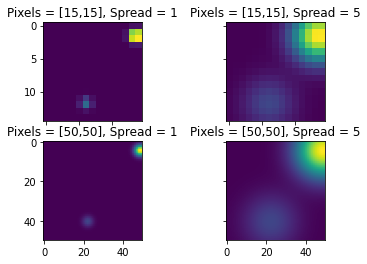

In [82]:
import persim
fig, axs = plt.subplots(2, 2)
p = [15,15]
s = 1
pim = PersImage(pixels=p, spread=s)
imgs_train = pim.transform(zero_dim_ltr_train[9])
axs[0, 0].imshow(imgs_train)
axs[0, 0].set_title("Pixels = [15,15], Spread = 1")
p = [15,15]
s = 5
pim = PersImage(pixels=p, spread=s)
imgs_train = pim.transform(zero_dim_ltr_train[9])
axs[0, 1].imshow(imgs_train)
axs[0, 1].set_title("Pixels = [15,15], Spread = 5")

p = [50,50]
s = 1
pim = PersImage(pixels=p, spread=s)
imgs_train = pim.transform(zero_dim_ltr_train[9])
axs[1, 0].imshow(imgs_train)
axs[1, 0].set_title("Pixels = [50,50], Spread = 1")

p = [50,50]
s = 5
pim = PersImage(pixels=p, spread=s)
imgs_train = pim.transform(zero_dim_ltr_train[9])
axs[1, 1].imshow(imgs_train)
axs[1, 1].set_title("Pixels = [50,50], Spread = 5")

for ax in axs.flat:
    ax.label_outer()


PersImage(pixels=[50, 50], spread=5, specs=None, kernel_type="gaussian", weighting_type="linear")


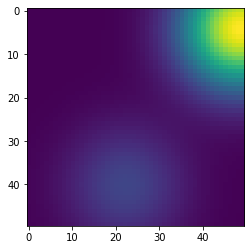

In [75]:
p = [50,50]
s = 5
import persim
pim = PersImage(pixels=p, spread=s)
imgs_train = pim.transform(zero_dim_ltr_train[9])
plt.imshow(imgs_train)

In [102]:
c = [1,2,3,5,10,20]
for i in c:
    clf = SVC(kernel='rbf', C=i).fit(X_train_features, y_train)
    print('C: ', i, "Train Accuracy: ", clf.score(X_train_features, y_train), "Test Accuracy: ", clf.score(X_test_features, y_test))

C:  1 Train Accuracy:  0.8166666666666667 Test Accuracy:  0.6916666666666667
C:  2 Train Accuracy:  0.8729166666666667 Test Accuracy:  0.7166666666666667
C:  3 Train Accuracy:  0.8958333333333334 Test Accuracy:  0.725
C:  5 Train Accuracy:  0.9239583333333333 Test Accuracy:  0.7208333333333333
C:  10 Train Accuracy:  0.9604166666666667 Test Accuracy:  0.7333333333333333
C:  20 Train Accuracy:  0.9822916666666667 Test Accuracy:  0.7166666666666667


### Kernel

In [105]:
for s in [.8, .9, 1, 1.1, 1.2, 1.3]:
    X_train_features_0_ltr_kernel, X_test_features_0_ltr_kernel = fast_kernel_features(zero_dim_ltr_train, zero_dim_ltr_test, s)
    svc_model = NuSVC(kernel='precomputed')
    svc_model.fit(X_train_features_0_ltr_kernel, y_train)
    print('sigma: ', s, 'Train Accuracy: ', svc_model.score(X_train_features_0_ltr_kernel, y_train), 'Test Accuracy: ', svc_model.score(X_test_features_0_ltr_kernel, y_test))

Total Time:  49.85992217063904
sigma:  0.8 Train Accuracy:  0.3175 Test Accuracy:  0.3
Total Time:  52.258851766586304
sigma:  0.9 Train Accuracy:  0.32125 Test Accuracy:  0.285
Total Time:  50.65521216392517
sigma:  1 Train Accuracy:  0.3175 Test Accuracy:  0.295
Total Time:  49.17490887641907
sigma:  1.1 Train Accuracy:  0.32375 Test Accuracy:  0.305
Total Time:  49.924320936203
sigma:  1.2 Train Accuracy:  0.3275 Test Accuracy:  0.31
Total Time:  49.76550912857056
sigma:  1.3 Train Accuracy:  0.33625 Test Accuracy:  0.305


In [106]:
for s in [.8, .9, 1, 1.1, 1.2, 1.3]:
    X_train_features_0_rtl_kernel, X_test_features_0_rtl_kernel = fast_kernel_features(zero_dim_rtl_train, zero_dim_rtl_test, s)
    svc_model = NuSVC(kernel='precomputed')
    svc_model.fit(X_train_features_0_rtl_kernel, y_train)
    print('sigma: ', s, 'Train Accuracy: ', svc_model.score(X_train_features_0_rtl_kernel, y_train), 'Test Accuracy: ', svc_model.score(X_test_features_0_rtl_kernel, y_test))

Total Time:  49.610880851745605
sigma:  0.8 Train Accuracy:  0.35375 Test Accuracy:  0.325
Total Time:  50.799957036972046
sigma:  0.9 Train Accuracy:  0.35 Test Accuracy:  0.32
Total Time:  51.92821002006531
sigma:  1 Train Accuracy:  0.375 Test Accuracy:  0.34
Total Time:  50.560139894485474
sigma:  1.1 Train Accuracy:  0.35 Test Accuracy:  0.325
Total Time:  51.69721603393555
sigma:  1.2 Train Accuracy:  0.35625 Test Accuracy:  0.33
Total Time:  52.873440742492676
sigma:  1.3 Train Accuracy:  0.36 Test Accuracy:  0.34


In [40]:
s = 1.2
X_train_features_0_ltr_kernel_0, X_test_features_0_ltr_kernel_0 = fast_kernel_features(zero_dim_ltr_train, zero_dim_ltr_test, s)
X_train_features_0_rtl_kernel_0, X_test_features_0_rtl_kernel_0 = fast_kernel_features(zero_dim_rtl_train, zero_dim_rtl_test,s)
X_train_features_0_ttb_kernel_0, X_test_features_0_ttb_kernel_0 = fast_kernel_features(zero_dim_ttb_train, zero_dim_ttb_test,s)
X_train_features_0_btt_kernel_0, X_test_features_0_btt_kernel_0 = fast_kernel_features(zero_dim_btt_train, zero_dim_btt_test,s)

X_train_features_1_ltr_kernel_0, X_test_features_1_ltr_kernel_0 = fast_kernel_features(one_dim_ltr_train, one_dim_ltr_test,s)
X_train_features_1_rtl_kernel_0, X_test_features_1_rtl_kernel_0 = fast_kernel_features(one_dim_rtl_train, one_dim_rtl_test,s)
X_train_features_1_ttb_kernel_0, X_test_features_1_ttb_kernel_0 = fast_kernel_features(one_dim_ttb_train, one_dim_ttb_test,s)
X_train_features_1_btt_kernel_0, X_test_features_1_btt_kernel_0 = fast_kernel_features(one_dim_btt_train, one_dim_btt_test,s)

Total Time:  52.616400957107544
Total Time:  52.14344906806946
Total Time:  50.45461416244507
Total Time:  50.612135887145996
Total Time:  49.621570110321045
Total Time:  49.813968896865845
Total Time:  50.33135414123535
Total Time:  50.11269283294678


In [43]:
train_kernel = X_train_features_1_btt_kernel + X_train_features_1_ttb_kernel + X_train_features_1_rtl_kernel + X_train_features_1_ltr_kernel + X_train_features_0_btt_kernel + X_train_features_0_ttb_kernel + X_train_features_0_rtl_kernel + X_train_features_0_ltr_kernel
test_kernel = X_test_features_1_btt_kernel + X_test_features_1_ttb_kernel + X_test_features_1_rtl_kernel + X_test_features_1_ltr_kernel + X_test_features_0_btt_kernel + X_test_features_0_ttb_kernel + X_test_features_0_rtl_kernel + X_test_features_0_ltr_kernel

In [44]:
svc_model = NuSVC(kernel='precomputed')
svc_model.fit(train_kernel, y_train)

print('Train/test classification accuracy with kernel functions')
print(svc_model.score(train_kernel, y_train))
print(svc_model.score(test_kernel, y_test))

Train/test classification accuracy with kernel functions
0.6975
0.695


### Landscapes

In [84]:
n = [2,3,4,5,6,7,8,9,10]
r = [50,100,200,300,400,500]

train_accuracy = []
test_accuracy = []
n_model = []
r_model = []
c_model = []
model_type = []

for i in n:
    for j in r:
        X_train_features_1_ltr_landscapes, X_test_features_1_ltr_landscapes = landscape_features(one_dim_ltr_train, one_dim_ltr_test, num_landscapes=i, resolution=j)
        X_train_features_0_ltr_landscapes, X_test_features_0_ltr_landscapes = landscape_features(zero_dim_ltr_train, zero_dim_ltr_test, num_landscapes=i, resolution=j)

        X_train_features_1_rtl_landscapes, X_test_features_1_rtl_landscapes = landscape_features(one_dim_rtl_train, one_dim_rtl_test, num_landscapes=i, resolution=j)
        X_train_features_0_rtl_landscapes, X_test_features_0_rtl_landscapes = landscape_features(zero_dim_rtl_train, zero_dim_rtl_test, num_landscapes=i, resolution=j)

        X_train_features_1_ttb_landscapes, X_test_features_1_ttb_landscapes = landscape_features(one_dim_ttb_train, one_dim_ttb_test, num_landscapes=i, resolution=j)
        X_train_features_0_ttb_landscapes, X_test_features_0_ttb_landscapes = landscape_features(zero_dim_ttb_train, zero_dim_ttb_test, num_landscapes=i, resolution=j)

        X_train_features_1_btt_landscapes, X_test_features_1_btt_landscapes = landscape_features(one_dim_btt_train, one_dim_btt_test, num_landscapes=i, resolution=j)
        X_train_features_0_btt_landscapes, X_test_features_0_btt_landscapes = landscape_features(zero_dim_btt_train, zero_dim_btt_test, num_landscapes=i, resolution=j)
        
        X_train_features = np.column_stack((X_train_features_1_ltr_landscapes,X_train_features_1_rtl_landscapes,X_train_features_1_ttb_landscapes,X_train_features_1_btt_landscapes,X_train_features_0_ltr_landscapes,X_train_features_0_rtl_landscapes,X_train_features_0_btt_landscapes,X_train_features_0_ttb_landscapes))
        X_test_features = np.column_stack((X_test_features_1_ltr_landscapes,X_test_features_1_rtl_landscapes,X_test_features_1_ttb_landscapes,X_test_features_1_btt_landscapes,X_test_features_0_ltr_landscapes,X_test_features_0_rtl_landscapes,X_test_features_0_btt_landscapes,X_test_features_0_ttb_landscapes))

        ridge_model = RidgeClassifier().fit(X_train_features, y_train)
        train_accuracy.append(ridge_model.score(X_train_features, y_train))
        test_accuracy.append(ridge_model.score(X_test_features, y_test))
        n_model.append(i)
        r_model.append(j)
        model_type.append('Ridge Regression')
        c_model.append(0)
        c = [1,2,3,5,10,20]
        for k in c:
            clf = SVC(kernel='rbf', C=k).fit(X_train_features, y_train)
            train_accuracy.append(clf.score(X_train_features, y_train))
            test_accuracy.append(clf.score(X_test_features, y_test))
            n_model.append(i)
            r_model.append(j)
            model_type.append('SVC')
            c_model.append(k)

Total Time:  0.15189194679260254
Total Time:  0.176072359085083
Total Time:  0.14165592193603516
Total Time:  0.19016194343566895
Total Time:  0.1470952033996582
Total Time:  0.16781187057495117
Total Time:  0.1486048698425293
Total Time:  0.16249656677246094
Total Time:  0.19603300094604492
Total Time:  0.2785360813140869
Total Time:  0.17625904083251953
Total Time:  0.23895907402038574
Total Time:  0.16452717781066895
Total Time:  0.22316622734069824
Total Time:  0.18213582038879395
Total Time:  0.21766018867492676
Total Time:  0.2569758892059326
Total Time:  0.34918785095214844
Total Time:  0.2671370506286621
Total Time:  0.3438241481781006
Total Time:  0.2591233253479004
Total Time:  0.3208162784576416
Total Time:  0.2411363124847412
Total Time:  0.3191232681274414
Total Time:  0.341541051864624
Total Time:  0.42445802688598633
Total Time:  0.34082913398742676
Total Time:  0.41970014572143555
Total Time:  0.32795190811157227
Total Time:  0.3831048011779785
Total Time:  0.3197650909

Total Time:  0.20193195343017578
Total Time:  0.16204595565795898
Total Time:  0.20049619674682617
Total Time:  0.22131609916687012
Total Time:  0.3059380054473877
Total Time:  0.23494815826416016
Total Time:  0.30645036697387695
Total Time:  0.2345278263092041
Total Time:  0.285808801651001
Total Time:  0.23102617263793945
Total Time:  0.26943516731262207
Total Time:  0.308657169342041
Total Time:  0.41638875007629395
Total Time:  0.3108479976654053
Total Time:  0.3945903778076172
Total Time:  0.30533909797668457
Total Time:  0.3625359535217285
Total Time:  0.30402112007141113
Total Time:  0.37284016609191895
Total Time:  0.37198805809020996
Total Time:  0.49334001541137695
Total Time:  0.3803670406341553
Total Time:  0.4757561683654785
Total Time:  0.37174201011657715
Total Time:  0.4379551410675049
Total Time:  0.3760249614715576
Total Time:  0.4420320987701416
Total Time:  0.4421210289001465
Total Time:  0.5962309837341309
Total Time:  0.47177910804748535
Total Time:  0.59222698211

In [85]:
landscape_results = pd.DataFrame()
landscape_results['Training Accuracy'] = train_accuracy
landscape_results['Test Accuracy'] = test_accuracy
landscape_results['n'] = n_model
landscape_results['r'] = r_model
landscape_results['c'] = c_model
landscape_results['Model Type'] = model_type

In [92]:
landscape_sorted = landscape_results.sort_values(by=['Test Accuracy', 'Training Accuracy'],ascending=False)
landscape_sorted[0:50]

,Training Accuracy,Test Accuracy,n,r,c,Model Type
6,0.91625,0.850,2,50,20,SVC
13,0.91625,0.850,2,100,20,SVC
20,0.91625,0.850,2,200,20,SVC
27,0.91625,0.850,2,300,20,SVC
34,0.91625,0.850,2,400,20,SVC
41,0.91625,0.850,2,500,20,SVC
55,0.91625,0.845,3,100,20,SVC
62,0.91625,0.845,3,200,20,SVC
69,0.91625,0.845,3,300,20,SVC
76,0.91625,0.845,3,400,20,SVC
